In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from kornia.contrib import connected_components

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
from uloss_wmh.loss_functions.neven import *

In [4]:
"""
I need to construct an example.
For that example, I need to construct an example vector map, a seed map
and two instances lets say.

I need a:

[ ] mask
[ ] example vector map
[ ] spatial dims
[ ] 
"""

'\nI need to construct an example.\nFor that example, I need to construct an example vector map, a seed map\nand two instances lets say.\n\nI need a:\n\n[ ] mask\n[ ] example vector map\n[ ] spatial dims\n[ ] \n'

### Example label mask

In [7]:
# example label mask
gt_mask = torch.zeros((100,100))
gt_mask[20:30, 78:92] = 1 # a retangle

# a circle
centre = torch.Tensor([60, 40])
radius = 10
grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in [100,100]],
                indexing='ij'
            )
        )



In [8]:
gt_instance_mask = torch.zeros((100,100))
gt_instance_mask[20:30, 78:92] = 2

In [9]:
xy_circle_masks = (((grid - centre.unsqueeze(1).unsqueeze(1))**2).sum(dim=0) - radius**2 < 0)
#gt_mask[torch.logical_and(xy_circle_masks[0], xy_circle_masks[1])] = 1

In [10]:
gt_mask[xy_circle_masks] = 1
gt_instance_mask[xy_circle_masks] = 1

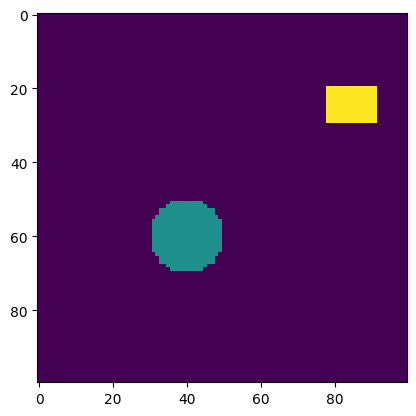

In [11]:
plt.imshow(gt_instance_mask)

### Example vector map

here I need to invent a prediction bya hypothetical model.
Lets say that it points every vector in a square around each object into the object's centre (maybe plus some noise?)
I will need two channels for an example, x and y.


In [12]:
offset_x_map = torch.zeros([100,100])
offset_y_map = torch.zeros([100,100])

# put a rectangle 12 pixels either side of the circle
offset_x_map[48:72, 28:52] = 62 - grid[0][48:72, 28:52]
offset_y_map[48:72, 28:52] = 38 - grid[1][48:72, 28:52]

# put a circle of radius 8 around the rectangle
rectangle_centre = torch.Tensor([25,85])
rect_pred_radius = 8
xy_example_pred_mask = (((grid - rectangle_centre.unsqueeze(1).unsqueeze(1))**2).sum(dim=0) - rect_pred_radius**2 < 0)
offset_x_map[xy_example_pred_mask] = (24 - grid[0][xy_example_pred_mask]).type(torch.float32)
offset_y_map[xy_example_pred_mask] = (84 - grid[1][xy_example_pred_mask]).type(torch.float32)

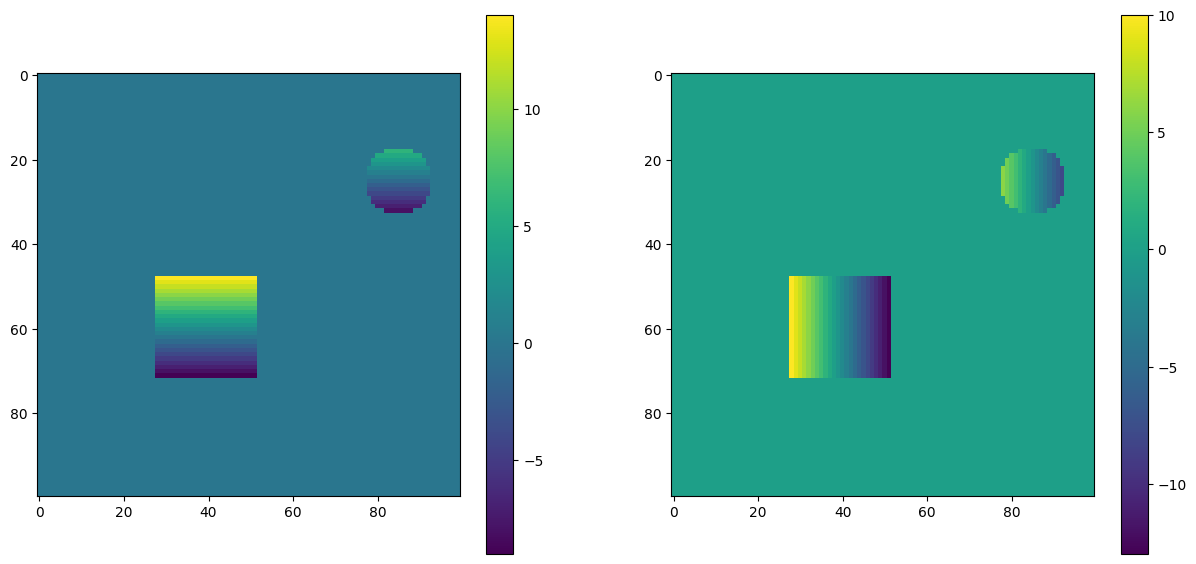

In [13]:
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.imshow(offset_x_map); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(offset_y_map); plt.colorbar();

### creating an example sigma map and an example seed map
I am just going to use a random vector for each of these, and just manually run through the loss with it and see
what I get...

In [14]:
log2pres = torch.randn((2,100,100))
seed = torch.randn((100,100))
sigma = (1/(2 * log2pres.exp())).sqrt()

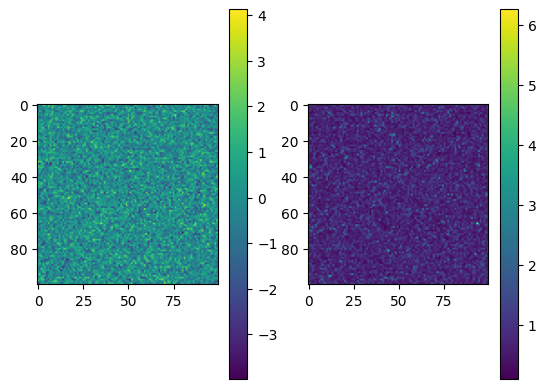

In [15]:
plt.subplot(1,2,1)
plt.imshow(seed); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sigma[0]); plt.colorbar()

this image would be a really good example to overfit on because it is so simple. Nice.

In [16]:
from monai.losses import DiceLoss

In [17]:
base_loss = DiceLoss(
    sigmoid=False,
    softmax=False
)

In [18]:
offset_x_map.requires_grad = True
offset_y_map.requires_grad = True
log2pres.requires_grad = True
seed.requires_grad = True

In [19]:
offset_x_map.grad

In [20]:
example_spatial_dims = [100,100]
example_label_instances = gt_instance_mask.unsqueeze(0).unsqueeze(0)
example_offsets = torch.stack([offset_x_map, offset_y_map]).unsqueeze(0)
example_log2press = log2pres.unsqueeze(0)
example_seed = seed.unsqueeze(0).unsqueeze(0)

In [21]:
# lets calculate each loss in turn:

# mean sigmas
mean_rectangle_sigma = sigma[:,20:30, 78:92].mean(dim=(1,2))
mean_circle_sigma = sigma[:,xy_circle_masks].mean(dim=1)
print("mean sigmas: ", mean_circle_sigma, mean_rectangle_sigma.detach())

# mean log2press
mean_rectangle_log2press = log2pres[:,20:30, 78:92].exp().mean(dim=(1,2)).log()
mean_circle_log2press = log2pres[:,xy_circle_masks].exp().mean(dim=1).log()
print("mean logs2press: ", mean_circle_log2press, mean_rectangle_log2press.detach())

# embedding_map x and y
# example_embedding = torch.stack([grid[0]/100 + offset_x_map.tanh(), grid[1]/100 + offset_y_map.tanh()])
# example_embedding = torch.stack([grid[0]/100 + offset_x_map/100, grid[1]/100 + offset_y_map/100])
example_embedding = torch.stack([grid[0] + offset_x_map, grid[1] + offset_y_map])


# calculate learned centre and fixed centre
fixed_centre_circle = centre#/100
fixed_centre_rectangle = torch.Tensor([24.5,84.5])#/100
learned_centre_circle = torch.Tensor([
    example_embedding[0][xy_circle_masks].mean(), example_embedding[1][xy_circle_masks].mean()
])
learned_centre_rectangle = torch.Tensor([example_embedding[0][20:30, 78:92].mean(), example_embedding[1][20:30, 78:92].mean()])

print("fixed centres: ", fixed_centre_circle, fixed_centre_rectangle.detach())
print("learned centres: ", learned_centre_circle, learned_centre_rectangle.detach())

# calculate instance distribution for each instance
circle_instance_distribution_fixed = (-(example_embedding - fixed_centre_circle.unsqueeze(-1).unsqueeze(-1)).pow(2) * mean_circle_log2press.unsqueeze(-1).unsqueeze(-1).exp()).sum(dim=0).exp()
circle_instance_distribution_learned = (-(example_embedding - learned_centre_circle.unsqueeze(-1).unsqueeze(-1)).pow(2) * mean_circle_log2press.unsqueeze(-1).unsqueeze(-1).exp()).sum(dim=0).exp()
rectangle_instance_distribution_fixed = (-(example_embedding - fixed_centre_rectangle.unsqueeze(-1).unsqueeze(-1)).pow(2) * mean_rectangle_log2press.unsqueeze(-1).unsqueeze(-1).exp()).sum(dim=0).exp()
rectangle_instance_distribution_learned = (-(example_embedding - learned_centre_rectangle.unsqueeze(-1).unsqueeze(-1)).pow(2) * mean_rectangle_log2press.unsqueeze(-1).unsqueeze(-1).exp()).sum(dim=0).exp()
print(" circle_instance_distribution_fixed sum and shape: ", circle_instance_distribution_fixed.sum().detach(), circle_instance_distribution_fixed.shape)
print(" circle_instance_distribution_learned sum and shape: ", circle_instance_distribution_learned.sum().detach(), circle_instance_distribution_learned.shape)
print(" rectangle_instance_distribution_fixed sum and shape: ", rectangle_instance_distribution_fixed.sum().detach(), rectangle_instance_distribution_fixed.shape)
print(" rectangle_instance_distribution_learned sum and shape: ", rectangle_instance_distribution_learned.sum().detach(), rectangle_instance_distribution_learned.shape)
# smooth loss
#print(mean_rectangle_sigma.shape)
rectangle_sigma_smooth_loss = (sigma[:,20:30, 78:92] - mean_rectangle_sigma.unsqueeze(-1).unsqueeze(-1)).pow(2).sum() / ((30-20) * (92-78))
circle_sigma_smooth_loss = (sigma[:,xy_circle_masks] - mean_circle_sigma.unsqueeze(-1)).pow(2).sum() / xy_circle_masks.sum()
print("circle sigma sum: ", (sigma[:,xy_circle_masks] - mean_circle_sigma.unsqueeze(-1)).pow(2).sum().detach())
print("circle mask sum: ", xy_circle_masks.sum().detach())
smooth_loss = rectangle_sigma_smooth_loss + circle_sigma_smooth_loss
print("\n--------------")
print("circle smooth loss", circle_sigma_smooth_loss.detach())
print("rectangle smooth loss", rectangle_sigma_smooth_loss.detach())
print("smooth loss", smooth_loss.detach())

# seed loss
background_seed_loss = seed[gt_instance_mask==0].pow(2).sum()
circle_seed_loss_fixed = (seed[gt_instance_mask==1] - circle_instance_distribution_fixed[gt_instance_mask==1]).pow(2).sum()
circle_seed_loss_learned = (seed[gt_instance_mask==1] - circle_instance_distribution_learned[gt_instance_mask==1]).pow(2).sum()
rectangle_seed_loss_fixed = (seed[gt_instance_mask==2] - rectangle_instance_distribution_fixed[gt_instance_mask==2]).pow(2).sum()
rectangle_seed_loss_learned = (seed[gt_instance_mask==2] - rectangle_instance_distribution_learned[gt_instance_mask==2]).pow(2).sum()
seed_loss_fixed = (background_seed_loss + circle_seed_loss_fixed + rectangle_seed_loss_fixed) / (100*100)
seed_loss_learnable = (background_seed_loss + circle_seed_loss_learned + rectangle_seed_loss_learned) / (100*100)
print("\n--------------")
print("background seed loss: ", background_seed_loss.detach())
print("fixed and learned seed loss circle: ", circle_seed_loss_fixed, circle_seed_loss_learned.detach())
print("fixed and learned seed loss rectangle: ", rectangle_seed_loss_fixed, rectangle_seed_loss_learned.detach())
print("seed loss fixed and learnable: ", seed_loss_fixed, seed_loss_learnable.detach())

# instance loss
instance_loss_circle_fixed = base_loss(circle_instance_distribution_fixed.unsqueeze(0).unsqueeze(0), (gt_instance_mask==1).unsqueeze(0).unsqueeze(0))
instance_loss_circle_learned = base_loss(circle_instance_distribution_learned.unsqueeze(0).unsqueeze(0), (gt_instance_mask==1).unsqueeze(0).unsqueeze(0))

instance_loss_rectangle_fixed = base_loss(rectangle_instance_distribution_fixed.unsqueeze(0).unsqueeze(0), (gt_instance_mask==2).unsqueeze(0).unsqueeze(0))
instance_loss_rectangle_learned = base_loss(rectangle_instance_distribution_learned.unsqueeze(0).unsqueeze(0), (gt_instance_mask==2).unsqueeze(0).unsqueeze(0))

instance_loss_fixed = (instance_loss_circle_fixed + instance_loss_rectangle_fixed)/2
instance_loss_learned = (instance_loss_circle_learned + instance_loss_rectangle_learned)/2

print("\n--------------")
print("fixed and learned instance loss circle: ", instance_loss_circle_fixed, instance_loss_circle_learned.detach())
print("fixed and learned instance loss rectangle: ", instance_loss_rectangle_fixed, instance_loss_rectangle_learned.detach())
print("instance loss fixed and learnable: ", instance_loss_fixed, instance_loss_learned.detach())

# overall loss
loss_fixed = instance_loss_fixed + seed_loss_fixed + smooth_loss
loss_learned = instance_loss_learned + seed_loss_learnable + smooth_loss
print("\n--------------")
print("loss fixed centre: ", loss_fixed.detach())
print("loss learnable centre: ", loss_learned.detach())

mean sigmas:  tensor([0.7656, 0.7865]) tensor([0.8216, 0.7643])
mean logs2press:  tensor([0.5969, 0.4626], grad_fn=<LogBackward0>) tensor([0.4754, 0.4064])
fixed centres:  tensor([60., 40.]) tensor([24.5000, 84.5000])
learned centres:  tensor([62., 38.]) tensor([23.9857, 83.8714])
 circle_instance_distribution_fixed sum and shape:  tensor(0.0007) torch.Size([100, 100])
 circle_instance_distribution_learned sum and shape:  tensor(576.) torch.Size([100, 100])
 rectangle_instance_distribution_fixed sum and shape:  tensor(88.6932) torch.Size([100, 100])
 rectangle_instance_distribution_learned sum and shape:  tensor(188.2072) torch.Size([100, 100])
circle sigma sum:  tensor(100.3656)
circle mask sum:  tensor(305)

--------------
circle smooth loss tensor(0.3291)
rectangle smooth loss tensor(0.3482)
smooth loss tensor(0.6772)

--------------
background seed loss:  tensor(9696.1104)
fixed and learned seed loss circle:  tensor(300.8976, grad_fn=<SumBackward0>) tensor(511.9900)
fixed and learn

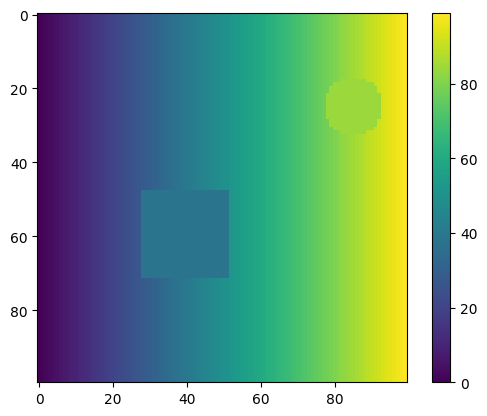

In [22]:
plt.imshow(example_embedding[1].detach()); plt.colorbar()

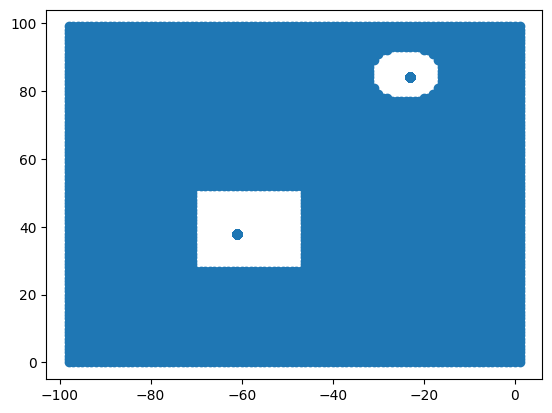

In [23]:
points = example_embedding.reshape((2,-1)).detach()
plt.scatter(1-points[0], points[1])

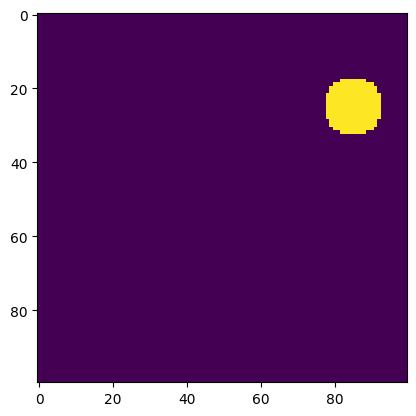

In [24]:
plt.imshow(rectangle_instance_distribution_fixed.detach())

In [25]:
points

tensor([[ 0.,  0.,  0.,  ..., 99., 99., 99.],
        [ 0.,  1.,  2.,  ..., 97., 98., 99.]])

In [26]:
loss_learned.backward()

In [27]:
offset_x_map.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]])

### Testing my implementation of neven

In [28]:
torch.Tensor([1,2]).shape

torch.Size([2])

In [29]:
%autoreload

In [30]:
from uloss_wmh.loss_functions.neven import *

In [31]:
neven_loss = NevenLoss(
    spatial_dims = (100,100),
    base_loss = base_loss,
    learnable_centre=True,
    instance_weight=1.,
    seed_weight=1.,
    smooth_weight=1.,
    detach_means=True,
    apply_l2p_adjustment=False
)

In [32]:
loss, _ = neven_loss(
    offset_vectors=example_offsets,
    log_2pres_squared=example_log2press,
    seed_map=example_seed,
    label_instances=example_label_instances,
)

In [33]:
loss

tensor(1.9672, grad_fn=<MeanBackward0>)

In [34]:
loss.backward()

In [35]:
# the gradients won't match because I haven't reset them
# just checking that they don't break
offset_x_map.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

### What needs to match:

- [x] sigma mean circle
- [x] sigma mean square
- [x] log2press mean circle
- [x] log2press mean square
- [x] instance loss learnable circle
- [x] instance loss learnable square
- [x] instance loss fixed circle
- [x] instance loss fixed square
- [x] smooth loss circle
- [x] smooth loss square
- [x] seed loss learnable circle
- [x] seed loss learnable square
- [x] seed loss fixed circle
- [x] seed loss fixed square
- [x] seed loss background
- [x] total instance loss fixed
- [x] total instance loss learned
- [x] total seed loss fixed
- [x] total seed loss learnable
- [x] total smooth loss
- [x] total loss

Note that the learned embeddings are off because of the use of tanh on the embeddings to scale them (as opposed
to dividing by 100 like for the fixed embeddings. However, the algorithm otherwise works!

### After getting this to work I need to try the following:

- [x] check that the gradient can track back through to the inputs
- [ ] implement a parameter for rescaling the embedding map and check that it is consistent? I haven't implemented this but I will see if I can overfit a single example first.

In [36]:
instance_loss_circle_fixed, instance_loss_circle_learned

(tensor(1.0000, grad_fn=<MeanBackward0>),
 tensor(0.3076, grad_fn=<MeanBackward0>))

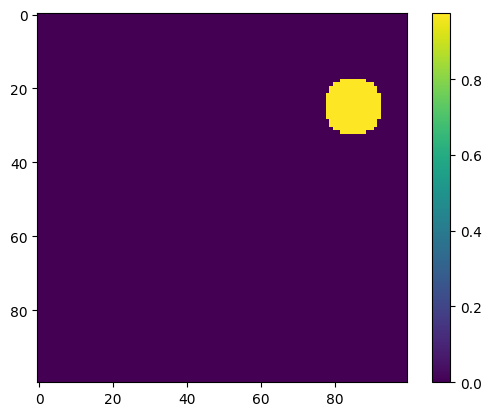

In [37]:
# im not sure that these learned distributions look right to be honest...
plt.imshow(rectangle_instance_distribution_learned.detach()); plt.colorbar()

In [38]:
sigma[:,20:30, 78:92].shape, mean_rectangle_sigma.unsqueeze(0).unsqueeze(0).shape

(torch.Size([2, 10, 14]), torch.Size([1, 1, 2]))

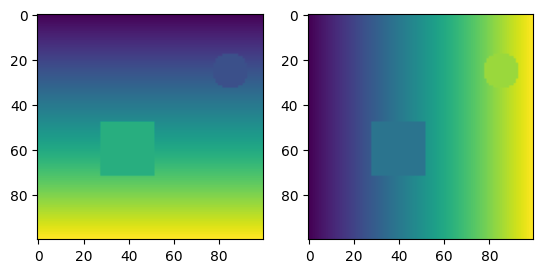

In [39]:
plt.subplot(1,2,1)
plt.imshow(example_embedding[0].detach())
plt.subplot(1,2,2)
plt.imshow(example_embedding[1].detach())

In [40]:
xy_circle_masks

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

### Overfitting on the one image

In [41]:
neven_loss = NevenLoss(
    spatial_dims = (100,100),
    base_loss = base_loss,
    learnable_centre=True,
    instance_weight=1.,
    seed_weight=1.,
    smooth_weight=1.,
    detach_means=True,
    apply_l2p_adjustment=True,
    l2p_tanh_scale=2,
    l2p_tanh_offset=4.6
)

In [42]:
# just define a random input embedding vector
offset_vector_random = torch.randn(1, 2, 100, 100).cuda() * 0.5
log_2pres_squared_random = torch.randn(1,2,100,100).cuda() #+ -2.02 #-3.9#torch.randn(1, 2, 100, 100) * 3
seed_map_random = torch.randn(1, 1, 100, 100).cuda()

class InputsWrapper(torch.nn.Module):
    def __init__(self, offset_vector_random, log_2pres_squared_random, seed_map_random):
        super().__init__()

        self.offset_vector_random = torch.nn.Parameter(offset_vector_random)
        self.log_2pres_squared_random = torch.nn.Parameter(log_2pres_squared_random)
        # self.log_2pres_squared_random = log_2pres_squared_random
        self.seed_map_random = torch.nn.Parameter(seed_map_random)
        self.instance_distributions = []
        
    def forward(self):
        loss, instance_distributions = neven_loss(
            offset_vectors=self.offset_vector_random,
            # log_2pres_squared=(self.log_2pres_squared_random.tanh() * 2) - 4.6,
            log_2pres_squared=self.log_2pres_squared_random,
            seed_map=self.seed_map_random,
            label_instances=example_label_instances.cuda(),
        )
        self.instance_distributions.append(instance_distributions)

        return loss

In [43]:
model = InputsWrapper(offset_vector_random, log_2pres_squared_random, seed_map_random)

In [44]:
optimizer = torch.optim.SGD(model.parameters(), lr=2)

In [56]:
for i in range(10000):
    loss = model()
    loss.backward()
    if i % 1000 == 0:
        print("LOSS: ", loss)
        print(model.offset_vector_random.data[0][0][60][40])
        print(model.offset_vector_random.grad[0][0][60][40])
    optimizer.step()
    optimizer.zero_grad()

LOSS:  tensor(0.1462, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0175, device='cuda:0')
tensor(4.1470e-06, device='cuda:0')
LOSS:  tensor(0.1347, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0100, device='cuda:0')
tensor(3.3555e-06, device='cuda:0')
LOSS:  tensor(0.1248, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0039, device='cuda:0')
tensor(2.6991e-06, device='cuda:0')
LOSS:  tensor(0.1161, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0009, device='cuda:0')
tensor(2.1510e-06, device='cuda:0')
LOSS:  tensor(0.1084, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0047, device='cuda:0')
tensor(1.6923e-06, device='cuda:0')
LOSS:  tensor(0.1015, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0077, device='cuda:0')
tensor(1.3123e-06, device='cuda:0')
LOSS:  tensor(0.0954, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0100, device='cuda:0')
tensor(1.0021e-06, device='cuda:0')
LOSS:  tensor(0.0899, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-

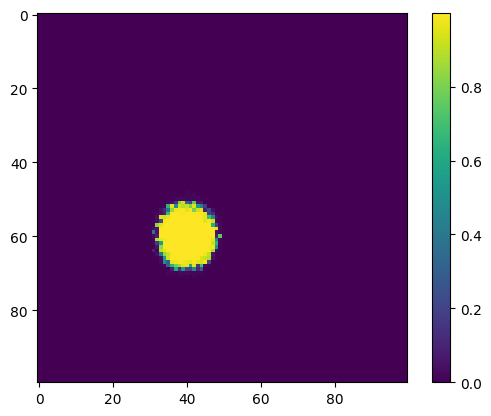

In [63]:
plt.imshow(model.instance_distributions[-1][0].cpu());
plt.colorbar();

In [64]:
example_label_instances.shape

torch.Size([1, 1, 100, 100])

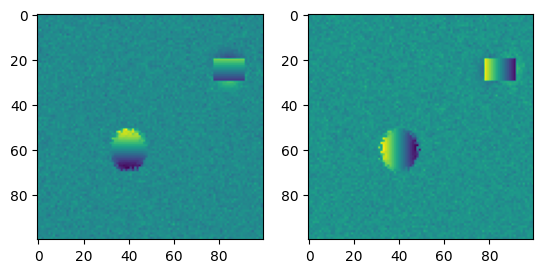

In [65]:
plt.subplot(1,2,1)
#offset_vector_random
#log_2pres_squared_random
#seed_map_random

#embedding = grid/100 + model.offset_vector_random.detach().tanh()
embedding = grid + model.offset_vector_random.detach().cpu()

# plt.imshow(embedding[0,1]); plt.colorbar()
# plt.imshow(model.log_2pres_squared_random[0,0].detach()); plt.colorbar()
# plt.imshow(model.seed_map_random[0,0].detach()); plt.colorbar()
plt.imshow(model.offset_vector_random.detach().cpu()[0,0]);# plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(model.offset_vector_random.detach().cpu()[0,1]);# plt.colorbar()

In [66]:
grid.shape

torch.Size([2, 100, 100])

In [67]:
dist = (-(embedding[0] - torch.Tensor([25,85]).reshape((2,1,1))).pow(2.)/(2 * (5 ** 2))).sum(dim=0).exp()

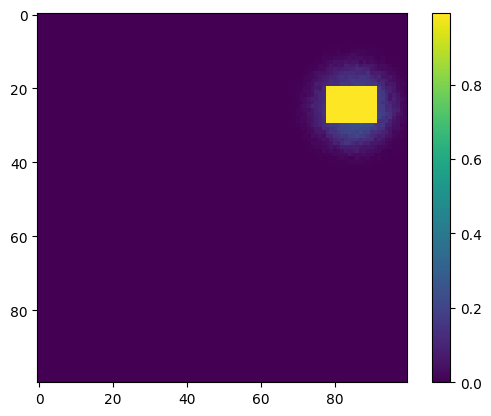

In [68]:
plt.imshow(dist); plt.colorbar()

In [69]:
points_random = embedding.reshape((2, -1))

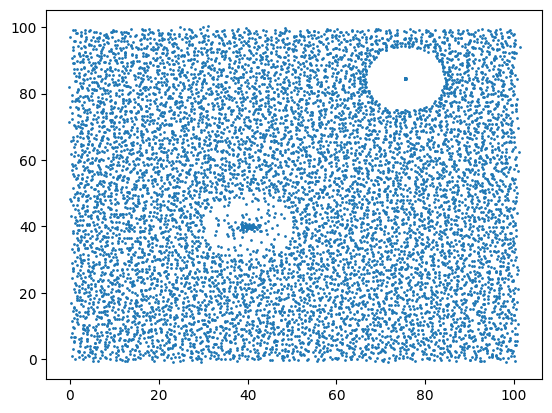

In [70]:
plt.scatter(100-points_random[0], points_random[1], s=1)

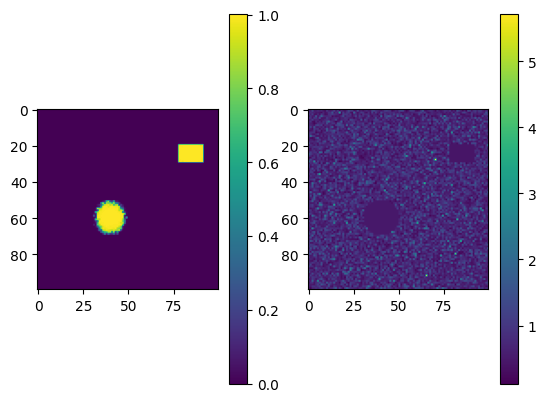

In [71]:
plt.subplot(1,2,1)
#offset_vector_random
#log_2pres_squared_random
#seed_map_random

sigma_random = (1./(2*model.log_2pres_squared_random.exp())).sqrt()
plt.imshow(model.seed_map_random[0,0].detach().cpu()); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sigma_random[0,0].detach().cpu()); plt.colorbar()

In [425]:
sigma_random[0,0,20]

tensor([0.4933, 0.6225, 0.3904, 0.3171, 1.5289, 0.3404, 0.6878, 0.3891, 0.6825,
        0.3979, 0.6603, 0.4198, 0.5545, 0.2808, 1.1185, 1.1562, 0.5918, 0.5147,
        0.3715, 1.0408, 0.7825, 1.2349, 0.4548, 0.8440, 0.5333, 0.5852, 0.7714,
        0.3632, 0.6069, 1.0095, 1.2187, 0.4575, 0.8774, 1.1053, 0.7362, 0.3202,
        0.8498, 1.0570, 1.1875, 0.5477, 0.5506, 2.9017, 0.3329, 0.6715, 1.7925,
        0.8632, 0.3657, 0.2612, 0.5520, 0.3831, 0.6895, 0.5252, 1.0347, 0.6801,
        2.1028, 0.4432, 0.3421, 0.5141, 0.2753, 0.8059, 0.3811, 0.4438, 0.2685,
        0.8256, 0.3737, 1.1987, 0.6410, 0.6424, 1.0222, 0.2857, 1.2017, 1.1901,
        1.0649, 1.1102, 0.7509, 0.5681, 0.6566, 2.5809, 0.4101, 0.4101, 0.4101,
        0.4101, 0.4101, 0.4101, 0.4101, 0.4101, 0.4101, 0.4101, 0.4101, 0.4101,
        0.4101, 0.4101, 0.8425, 0.2972, 0.7053, 0.2666, 0.2365, 0.4882, 0.9495,
        0.7527], device='cuda:0', grad_fn=<SelectBackward0>)

### list of what is working or needs checking

- [x] trains with fixed centre and full scale vectors
- [x] trains with learned centre and full scale vectors (yes works even better)
- [ ] scaling down the vectors, does it still train?
- [ ] finding a suitable way to constrain log2pres does it train?